<a href="https://colab.research.google.com/github/AjeetSingh02/TimeSeries/blob/master/TimeSeriesUnivariateLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

Here we will see how to develop an LSTM forecast model for a one-step univariate time series forecasting problem.

**Tutorial Overview**

This tutorial is broken down into 9 parts; they are:

1. Shampoo Sales Dataset
2. Test Setup
3. Persistence Model Forecast
4. LSTM Data Preparation
5. LSTM Model Development
6. LSTM Forecast
7. Complete LSTM Example
8. Develop a Robust Result
9. Tutorial Extensions

Requirements:
1. Python 2/3
2. SciPy. 
3. Keras (2.0 or higher) with either the TensorFlow or Theano backend.
4. scikit-learn
5. Pandas
6. NumPy
7. Matplotlib

# Shampoo Sales Dataset

This dataset describes the monthly number of sales of shampoo over a 3-year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

[dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv)

In [0]:
# Downloading the dataset in notebook
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2020-01-28 04:57:44--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plain]
Saving to: ‘shampoo.csv’

shampoo.csv         100%[===================>]     519  --.-KB/s    in 0s      

2020-01-28 04:57:45 (57.9 MB/s) - ‘shampoo.csv’ saved [519/519]



In [0]:
from math import sqrt
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [0]:
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')
 
series = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [0]:
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

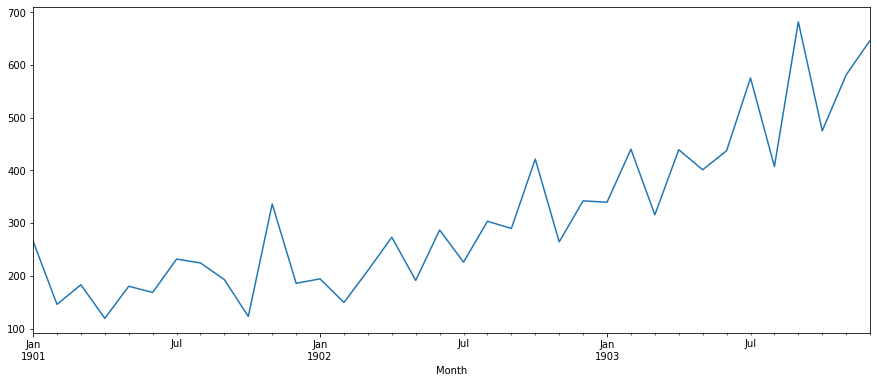

In [0]:
series.plot()
plt.show()

# Test Setup

We will split the Shampoo Sales dataset into two parts: a training and a test set.

The first two years of data will be taken for the training dataset and the remaining one year of data will be used for the test set.

In [0]:
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

Models will be developed using the training dataset and will make predictions on the test dataset.

**A rolling forecast scenario will be used, also called walk-forward model validation.**

**Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.**

In [0]:
# Example
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction...
    pass

**This mimics a real-world scenario where new Shampoo Sales observations would be available each month and used in the forecasting of the following month.**

Finally, all forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

#Persistence Model Forecast
A good baseline forecast for a time series with a linear increasing trend is a persistence forecast.

The persistence forecast is where the observation from the prior time step (t-1) is used to predict the observation at the current time step (t).

We can implement this by taking the last observation from the training data and history accumulated by walk-forward validation and using that to predict the current time step.

We will accumulate all predictions in an array so that they can be directly compared to the test dataset.

In [0]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction on last element of history
	predictions.append(history[-1])
	# add one element from test into history
	history.append(test[i])

In [0]:
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 136.761


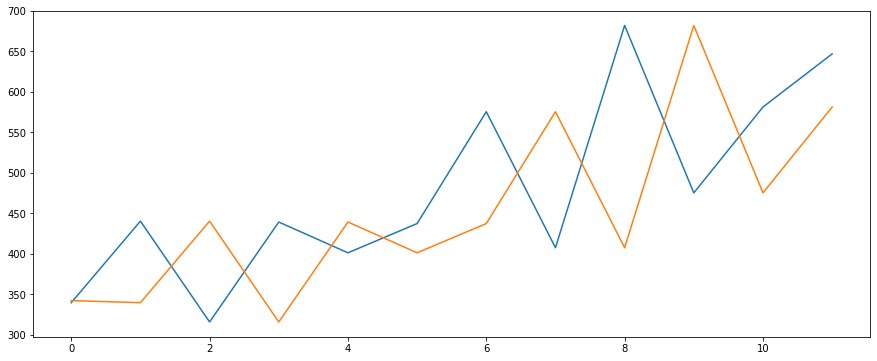

In [0]:
# line plot of observed vs predicted
plt.plot(test)
plt.plot(predictions)
plt.show()

This result is so poor because we have not trained any model. This is 
just for demonstration. Like how we are going to update our history
and make new predictions.

This is like at each step the ith value is used to predict (i+1)th value
and then the (i+1)th value is used to predict (i+2)th value.
and so on.

Now that we have a baseline of performance on the dataset, we can get started developing an LSTM model for the data.

#LSTM Data Preparation
Before we can fit an LSTM model to the dataset, we must transform the data.

This section is broken down into three steps:

1. Transform the time series into a supervised learning problem
2. Transform the time series data so that it is stationary.
3. Transform the observations to have a specific scale.

**1. Transform Time Series to Supervised Learning**

The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.

We can then concatenate these two series together to create a DataFrame ready for supervised learning. The pushed-down series will have a new position at the top with no value. A NaN (not a number) value will be used in this position. We will replace these NaN values with 0 values, which the LSTM model will have to learn as “the start of the series” or “I have no data here,” as a month with zero sales on this dataset has not been observed.

The code below defines a helper function to do this called timeseries_to_supervised(). It takes a NumPy array of the raw time series data and a lag or number of shifted series to create and use as inputs.

In [0]:
# frame a sequence as a supervised learning problem
# data -> Numpy array

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data) #create a dataset from the numpy array
    
    # will make column(s) with shift one more than previous column(if any)
    columns = [df.shift(i) for i in range(1, lag+1)] 
    
    columns.append(df) # Append the original series into columns
    df = pd.concat(columns, axis=1) # Make a new dataset out of all the columns
    df.fillna(0, inplace=True) # Replace all NaNs with 0
    return df

In [0]:
# Example to demonstrate above function
dd = timeseries_to_supervised(train, lag=3)
dd.head()

,0,0,0,0
0,0.0,0.0,0.0,266.0
1,266.0,0.0,0.0,145.9
2,145.9,266.0,0.0,183.1
3,183.1,145.9,266.0,119.3
4,119.3,183.1,145.9,180.3


In [0]:
# Applying on our shampoo dataset (whole dataset)
supervised = timeseries_to_supervised(X, 1)
supervised.head()

,0,0
0,0.0,266.0
1,266.0,145.9
2,145.9,183.1
3,183.1,119.3
4,119.3,180.3


**2. Transform Time Series to Stationary**
The Shampoo Sales dataset is not stationary.

This means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.

Stationary data is easier to model and will very likely result in more skillful forecasts.

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

We can achieve this automatically using the diff() function in pandas. Alternatively, we can get finer grained control and write our own function to do this, which is preferred for its flexibility in this case.

Below is a function called difference() that calculates a differenced series. Note that the first observation in the series is skipped as there is no prior observation with which to calculate a differenced value.

In [0]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
    # Start from i==interval so as to skip interval terms 
    # as they will not be having any past info
    # Then minus the (i-1)th term from ith term
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

We also need to invert this process in order to take forecasts made on the differenced series back into their original scale.

The function below, called inverse_difference(), inverts this operation.

In [0]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

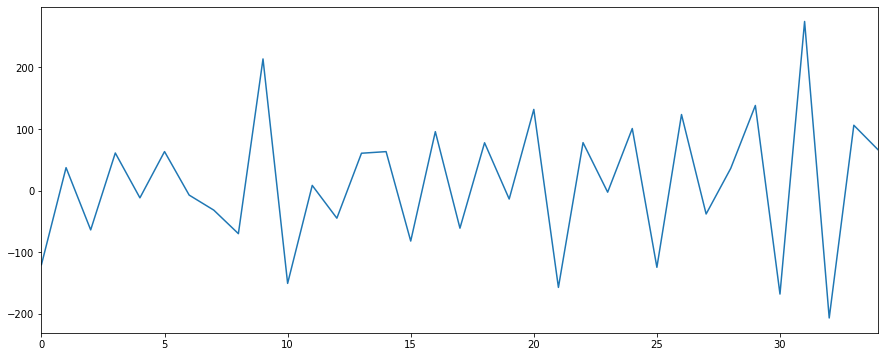

In [0]:
# transform to be stationary
differenced = difference(series, 1)
differenced.plot()

We can see that the trend has been removed

In [0]:
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = pd.Series(inverted)

In [0]:
print(series.head())
print(differenced.head())
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


38

Look at the above output to understand the operation.
Note that 1st value was removed as it doesn't have anything before it.

**3. Transform Time Series to Scale**

Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

To make the experiment fair, the scaling coefficients (min and max) values must be calculated on the training dataset and applied to scale the test dataset and any forecasts. This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

We can transform the dataset to the range [-1, 1] using the MinMaxScaler class. Like other scikit-learn transform classes, it requires data provided in a matrix format with rows and columns. Therefore, we must reshape our NumPy arrays before transforming.

In [0]:
from sklearn.preprocessing import MinMaxScaler
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:, 0])

Again, we must invert the scale on forecasts to return the values back to the original scale so that the results can be interpreted and a comparable error score can be calculated.

In [0]:
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])

In [0]:
print(series.head())
print(scaled_series.head())
print(inverted_series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64
0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


The above output shows the state of the scaling

# LSTM Model Development

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: **[samples, time steps, features]**.

Samples: These are independent observations from the domain, typically rows of data.

Time steps: These are separate time steps of a given variable for a given observation.

Features: These are separate measures observed at the time of observation.

We have some flexibility in how the Shampoo Sales dataset is framed for the network. We will keep it simple and frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature.

Given that the training dataset is defined as X inputs and y outputs, it must be reshaped into the Samples/TimeSteps/Features format.

We can use pandas reshape function for this.

In [0]:
# Dont run. Its an example to explain steps
X, y = train[:, 0:-1], train[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])

The shape of the input data must be specified in the LSTM layer using the “batch_input_shape” argument as a tuple that specifies the expected number of observations to read each batch, the number of time steps, and the number of features.

The batch size is often much smaller than the total number of samples. It, along with the number of epochs, defines how quickly the network learns the data (how often the weights are updated).

The final import parameter in defining the LSTM layer is the number of neurons, also called the number of memory units or blocks. This is a reasonably simple problem and a number between 1 and 5 should be sufficient.

The line below creates a single LSTM hidden layer that also specifies the expectations of the input layer via the “batch_input_shape” argument.


In [0]:
# Dont run. Its an example to explain steps
layer = LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)

The network requires a single neuron in the output layer with a linear activation to predict the number of shampoo sales at the next time step.

Once the network is specified, it must be compiled into an efficient symbolic representation using a backend mathematical library, such as TensorFlow or Theano.

In compiling the network, we must specify a loss function and optimization algorithm. We will use “mean_squared_error” as the loss function as it closely matches RMSE that we will are interested in, and the efficient ADAM optimization algorithm.

Using the Sequential Keras API to define the network, the below snippet creates and compiles the network.

In [0]:
# Dont run. Its an example to explain steps

model = Sequential()
#Adding the layer of previous state
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

Once compiled, it can be fit to the training data. Because the network is stateful, we must control when the internal state is reset. Therefore, we must manually manage the training process one epoch at a time across the desired number of epochs.

By default, the samples within an epoch are shuffled prior to being exposed to the network. Again, this is undesirable for the LSTM because we want the network to build up state as it learns across the sequence of observations. We can disable the shuffling of samples by setting “shuffle” to “False“.

Also by default, the network reports a lot of debug information about the learning progress and skill of the model at the end of each epoch. We can disable this by setting the “verbose” argument to the level of “0“.

We can then reset the internal state at the end of the training epoch, ready for the next training iteration.

Below is a loop that manually fits the network to the training data.

In [0]:
# Dont run. Its an example to explain steps
for i in range(nb_epoch):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	model.reset_states()

Putting this all together, we can define a function called fit_lstm() that trains and returns an LSTM model. As arguments, it takes the training dataset in a supervised learning format, a batch size, a number of epochs, and a number of neurons.

In [0]:
# Dont run. Its an example to explain steps
# This function will do all of the above steps 
# described in LSTM Model Development
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

The batch_size must be set to 1. This is because it must be a factor of the size of the training and test datasets.

The predict() function on the model is also constrained by the batch size; there it must be set to 1 because we are interested in making one-step forecasts on the test data.

We will not tune the network parameters in this tutorial; instead we will use the following configuration, found with a little trial and error:

      Batch Size: 1
      Epochs: 3000
      Neurons: 4

As an extension to this tutorial, you might like to explore different model parameters and see if you can improve performance.

Consider trying 1500 epochs and 1 neuron, the performance may be better!

# LSTM Forecast

Once the LSTM model is fit to the training data, it can be used to make forecasts.

Again, we have some flexibility. We can decide to fit the model once on all of the training data, then predict each new time step one at a time from the test data (we’ll call this the fixed approach), or we can re-fit the model or update the model each time step of the test data as new observations from the test data are made available (we’ll call this the dynamic approach).

In this tutorial, we will go with the fixed approach for its simplicity, although, we would expect the dynamic approach to result in better model skill.

To make a forecast, we can call the predict() function on the model. This requires a 3D NumPy array input as an argument. In this case, it will be an array of one value, the observation at the previous time step.

The predict() function returns an array of predictions, one for each input row provided. Because we are providing a single input, the output will be a 2D NumPy array with one value.

We can capture this behavior in a function named forecast() listed below. Given a fit model, a batch-size used when fitting the model (e.g. 1), and a row from the test data, the function will separate out the input data from the test row, reshape it, and return the prediction as a single floating point value.

In [0]:
def forecast(model, batch_size, row):
	X = row[0:-1]
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

During training, the internal state is reset after each epoch. While forecasting, we will not want to reset the internal state between forecasts. In fact, we would like the model to build up state as we forecast each time step in the test dataset.

This raises the question as to what would be a good initial state for the network prior to forecasting the test dataset.

In this tutorial, we will seed the state by making a prediction on all samples in the training dataset. In theory, the internal state should be set up ready to forecast the next time step.

We now have all of the pieces to fit an LSTM Network model for the Shampoo Sales dataset and evaluate its performance.

In the next section, we will put all of these pieces together.

#Complete LSTM Example
In this section, we will fit an LSTM to the Shampoo Sales dataset and evaluate the model.

This will involve drawing together all of the elements from the prior sections. There are a lot of them, so let’s review:

1. Load the dataset from CSV file.
2. Transform the dataset to make it suitable for the LSTM model, including:

       Transforming the data to a supervised learning problem.

       Transforming the data to be stationary.

       Transforming the data so that it has the scale -1 to 1.

3. Fitting a stateful LSTM network model to the training data.
4. Evaluating the static LSTM model on the test data.
5. Report the performance of the forecasts.

Some things to note about the example:

The scaling and inverse scaling behaviors have been moved to the functions scale() and invert_scale() for brevity.

The test data is scaled using the fit of the scaler on the training data, as is required to ensure the min/max values of the test data do not influence the model.

The order of data transforms was adjusted for convenience to first make the data stationary, then a supervised learning problem, then scaled.

Differencing was performed on the entire dataset prior to splitting into train and test sets for convenience. We could just as easily collect observations during the walk-forward validation and difference them as we go. I decided against it for readability.

The complete example is listed below.

In [0]:
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt

from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# date-time parsing function for loading the dataset
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [0]:
# load dataset
series = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [0]:
# fit the model
train, batch_size, nb_epoch, neurons = train_scaled, 1, 3000, 4
lstm_model = fit_lstm(train, batch_size, nb_epoch, neurons)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
pred = lstm_model.predict(train_reshaped, batch_size=1)

In [0]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=314.876082, Expected=339.700000
Month=2, Predicted=379.244132, Expected=440.400000
Month=3, Predicted=371.963904, Expected=315.900000
Month=4, Predicted=395.463316, Expected=439.300000
Month=5, Predicted=346.693512, Expected=401.300000
Month=6, Predicted=474.806945, Expected=437.400000
Month=7, Predicted=450.234991, Expected=575.500000
Month=8, Predicted=491.021862, Expected=407.600000
Month=9, Predicted=502.865039, Expected=682.000000
Month=10, Predicted=575.863335, Expected=475.300000
Month=11, Predicted=564.326993, Expected=581.300000
Month=12, Predicted=511.221594, Expected=646.900000


In [0]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 90.070


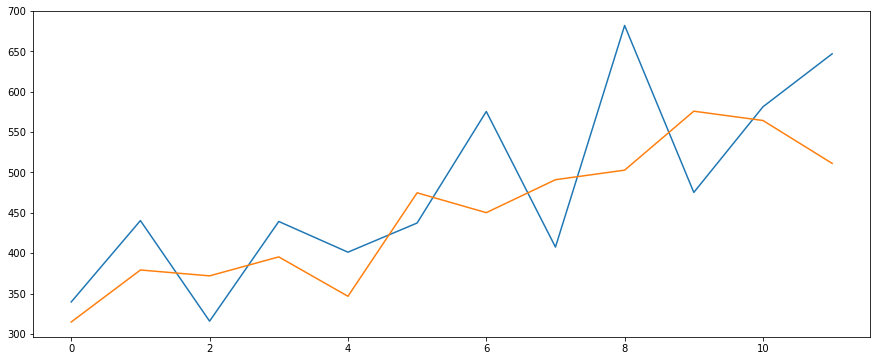

In [0]:
# line plot of observed vs predicted
plt.plot(raw_values[-12:])
plt.plot(predictions)
plt.show()

#Develop a Robust Result

A difficulty with neural networks is that they give different results with different starting conditions.

One approach might be to fix the random number seed used by Keras to ensure the results are reproducible. Another approach would be to control for the random initial conditions using a different experimental setup.

We can repeat the experiment from the previous section multiple times, then take the average RMSE as an indication of how well the configuration would be expected to perform on unseen data on average.

This is often called multiple repeats or multiple restarts.

We can wrap the model fitting and walk-forward validation in a loop of fixed number of repeats. Each iteration the RMSE of the run can be recorded. We can then summarize the distribution of RMSE scores.

In [0]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

The data preparation would be the same as before.

We will use 30 repeats as that is sufficient to provide a good distribution of RMSE scores.

The complete example is listed below.

1) Test RMSE: 95.298
2) Test RMSE: 87.022
3) Test RMSE: 160.587
4) Test RMSE: 232.576
5) Test RMSE: 91.872
6) Test RMSE: 150.551
7) Test RMSE: 110.556
8) Test RMSE: 112.320
9) Test RMSE: 89.145
10) Test RMSE: 221.299
11) Test RMSE: 134.747
12) Test RMSE: 144.504
13) Test RMSE: 274.488
14) Test RMSE: 207.134
15) Test RMSE: 100.507
16) Test RMSE: 92.250
17) Test RMSE: 155.091
18) Test RMSE: 108.680
19) Test RMSE: 162.531
20) Test RMSE: 107.158
21) Test RMSE: 85.330
22) Test RMSE: 85.904
23) Test RMSE: 104.869
24) Test RMSE: 94.277
25) Test RMSE: 109.183
26) Test RMSE: 88.791
27) Test RMSE: 131.924
28) Test RMSE: 135.385
29) Test RMSE: 117.971
30) Test RMSE: 133.421
             rmse
count   30.000000
mean   130.845741
std     48.153992
min     85.330448
25%     94.532256
50%    111.438140
75%    149.039462
max    274.488260


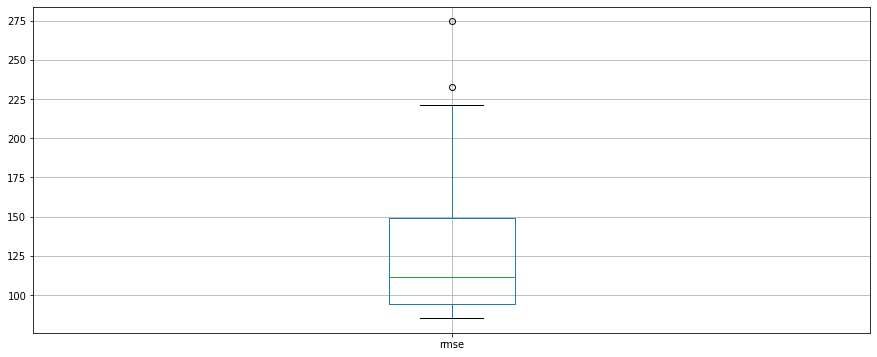

In [0]:
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt

from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# date-time parsing function for loading the dataset
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


# load dataset
series = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.show()

Running the example prints the RMSE score each repeat. The end of the run provides summary statistics of the collected RMSE scores.

We can see that the mean and standard deviation RMSE scores are 136.824368 and 51.547265 monthly shampoo sales respectively.

This is a very useful result as it suggests the result reported above was probably a statistical fluke. The experiment suggests that the model is probably about as good as the persistence model on average (136.761), if not slightly worse.

This indicates that, at the very least, further model tuning is required.

#Tutorial Extensions
There are many extensions to this tutorial that we may consider.




*   **Multi-Step Forecast**. The experimental setup could be changed to predict the next n-time steps rather than the next single time step. This would also permit a larger batch size and faster training. Note that we are basically performing a type of 12 one-step forecast in this tutorial given the model is not updated, although new observations are available and are used as input variables.
*   **Tune LSTM model**. The model was not tuned; instead, the configuration was found with some quick trial and error. I believe much better results could be achieved by tuning at least the number of neurons and number of training epochs. I also think early stopping via a callback might be useful during training.

*  **Seed State Experiments**. It is not clear whether seeding the system prior to forecasting by predicting all of the training data is beneficial. It seems like a good idea in theory, but this needs to be demonstrated. Also, perhaps other methods of seeding the model prior to forecasting would be beneficial.

* **Update Model**. The model could be updated in each time step of the walk-forward validation. Experiments are needed to determine if it would be better to refit the model from scratch or update the weights with a few more training epochs including the new sample.

* **Input Time Steps**. The LSTM input supports multiple time steps for a sample. Experiments are needed to see if including lag observations as time steps provides any benefit.

* **Input Lag Features**. Lag observations may be included as input features. Experiments are needed to see if including lag features provide any benefit, not unlike an AR(k) linear model.

* **Input Error Series**. An error series may be constructed (forecast error from a persistence model) and used as an additional input feature, not unlike an MA(k) linear model. Experiments are needed to see if this provides any benefit.

* **Learn Non-Stationary**. The LSTM network may be able to learn the trend in the data and make reasonable predictions. Experiments are needed to see if temporal dependent structures, like trends and seasonality, left in data can be learned and effectively predicted by LSTMs.

* **Contrast Stateless**. Stateful LSTMs were used in this tutorial. The results should be compared with stateless LSTM configurations.

* **Statistical Significance**. The multiple repeats experimental protocol can be extended further to include statistical significance tests to demonstrate whether the difference between populations of RMSE results with different configurations are statistically significant.



#Summary
In this tutorial, you discovered how to develop an LSTM model for time series forecasting.

Specifically, you learned:

* How to prepare time series data for developing an LSTM model.
* How to develop an LSTM model for time series forecasting.
* How to evaluate an LSTM model using a robust test harness.